## Traffic Sign Recognition with Tensorflow Keras

The goal is to build a model that can detect and classify traffic signs in a video stream taken from a moving car. Given an image of a traffic sign, our model should be able to tell it's type (*e.g. Stop sign, speed limit, yield sign*). We'll work with images that are properly cropped such that the traffic sign takes most of the image. So don't worry about edge cases as of now.

You are free to use either Keras or Pytorch.

We will use the **Belgian Traffic Sign** Dataset because it is big enough to train on, and yet small enough to be easy to work with.

You can download the dataset from : http://people.ee.ethz.ch/~timofter/traffic_signs/index.html

There are a lot of datasets on that page, but you only need the two files listed under BelgiumTS for Classification (cropped images):



1.   BelgiumTSC_Training 
2.   BelgiumTSC_Testing



The images in this dataset are in an old .ppm format. So old, in fact, that most tools don’t support it. Which meant that we cann’t casually browse the folders to take a look at the images. Luckily, the Scikit Image library recognizes this format. This code below will load the data and return two lists: images and labels.

In [0]:
# Another web link to download the dataset
#! wget https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Training.zip
#! unzip -q BelgiumTSC_Training.zip
#! wget https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Testing.zip
#! unzip -q BelgiumTSC_Testing.zip

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
root_dir = "/content/gdrive/My Drive/Deep Learning Class/Project/Belgian Traffic Sign Detector"

#Preprocessing of Dataset
I have done the preprocessing of the image files in the following notebook uploaded in Github.
I have usked Skimage package to convert .ppm format to numpy array
Numpy files are saved in .npy format and uploaded in my google drive.

https://github.com/dee-walia20/Belgian_Traffic_Sign_Detector/blob/master/data_preprocessing.ipynb


In [0]:
import numpy as np
import os
X_train = np.load(os.path.join(root_dir,"train_images_numpy.npy"))
X_test = np.load(os.path.join(root_dir,"test_images_numpy.npy"))

![picture](https://drive.google.com/uc?id=1BMOBI15uhip7e16qUR9n-rnSDQQlLv1p)

In [0]:
print(np.shape(X_train))
print(np.shape(X_test))

(4575, 64, 64, 3)
(2520, 64, 64, 3)


In [0]:
from tensorflow.keras.utils import to_categorical
y_train = np.load(os.path.join(root_dir,"train_labels_numpy.npy"))
y_train = to_categorical(y_train, num_classes=62)

y_test = np.load(os.path.join(root_dir,"test_labels_numpy.npy"))
y_test = to_categorical(y_test, num_classes=62)

In [0]:
print(np.shape(y_train))
print(np.shape(y_test))

(4575, 62)
(2520, 62)


#Visualization of each image class

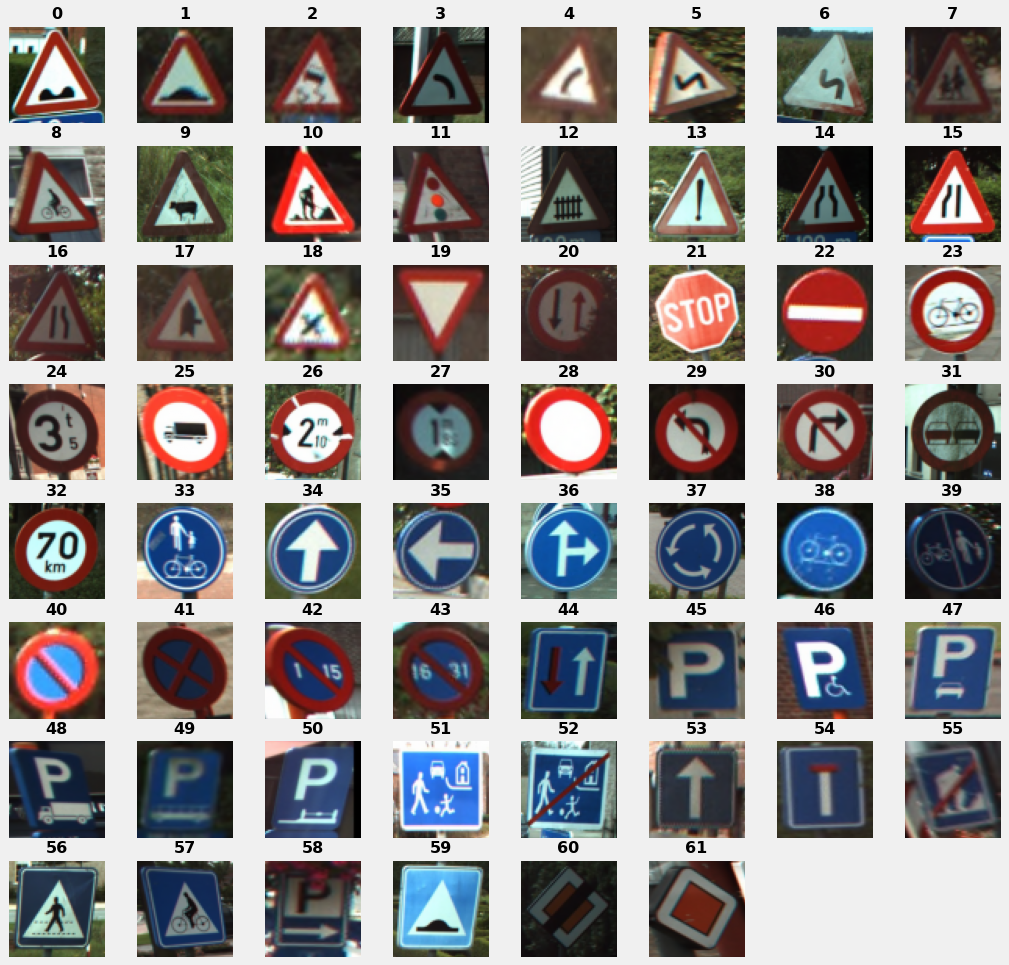

In [0]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,16))
for j, label in enumerate(np.unique(np.argmax(y_train, axis=1))):
    for i,img in enumerate(X_train):
        if label == np.argmax(y_train, axis=1)[i]:
            plt.subplot(8,8,j+1)
            plt.grid(False)
            plt.xticks([])
            plt.yticks([])
            plt.title(label, fontsize=16,fontweight='bold')
            plt.imshow(img)
            break

In [0]:
label_num = np.load(os.path.join(root_dir,"train_labels_numpy.npy"))

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1, stratify=label_num)

In [0]:
print(np.shape(X_train))
print(np.shape(X_val))

(3660, 64, 64, 3)
(915, 64, 64, 3)


#Data Augumentation

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=0.15,
                             height_shift_range=0.15,
                             zoom_range=0.15)

In [0]:
train_aug = datagen.flow(X_train, y_train,batch_size=128)

In [0]:
test_datagen=ImageDataGenerator()

In [0]:
val_aug = test_datagen.flow(X_val,y_val, batch_size=128, shuffle=False)
test_aug = test_datagen.flow(X_test,y_test, batch_size=128, shuffle=False)

#Create Model using pre-trained VGG16

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.applications import VGG16

In [0]:
IMG_Height = 64
IMG_Width = 64

In [0]:
model_1 = VGG16(include_top=False, weights='imagenet', input_shape=(IMG_Height, IMG_Width,3))
model_1 = Model(inputs = model_1.input, outputs = model_1.layers[-5].output)

for layer in model_1.layers:
    layer.trainable = False

model_2 = VGG16(include_top=False, weights='imagenet', input_shape=(IMG_Height, IMG_Width,3))

x = model_1.output
for layer in model_2.layers[-4::1]:
    x = (layer)(x)

x = Conv2D(64,3,padding = 'same', activation='relu')(x)
x = Flatten()(x)
x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.001))(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.001))(x)
x = Dropout(0.2)(x)
x = Dense(62, activation='softmax' )(x)

model = Model(inputs = model_1.input, outputs = x)

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

58892288/58889256 [==============================] - 2s 0us/step


In [0]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0   

In [0]:
tf.config.experimental_run_functions_eagerly(True)
#In TensorFlow 2.0, Eager execution lets you run the code step-by-step to inspect shapes, 
#data types and values. Certain APIs, like tf.function, tf.keras, etc. are designed to use Graph execution, 
#for performance and portability. When debugging, use tf.config.experimental_run_functions_eagerly(True) 
#to use Eager execution inside this code.

#Model Training

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath = 'traffic_model.hdf5', monitor='val_loss', save_best_only=True)
history = model.fit(train_aug, validation_data=val_aug, callbacks=checkpoint, steps_per_epoch= (3660 // 128), epochs=500)

Epoch 1/500
28/28 [==============================] - 14s 504ms/step - loss: 4.5423 - accuracy: 0.1611 - val_loss: 4.4431 - val_accuracy: 0.2262
Epoch 2/500
28/28 [==============================] - 11s 402ms/step - loss: 4.3915 - accuracy: 0.2664 - val_loss: 4.3499 - val_accuracy: 0.2896
Epoch 3/500
28/28 [==============================] - 11s 403ms/step - loss: 4.2847 - accuracy: 0.3511 - val_loss: 4.1717 - val_accuracy: 0.4470
Epoch 4/500
28/28 [==============================] - 11s 403ms/step - loss: 4.1338 - accuracy: 0.4827 - val_loss: 4.0967 - val_accuracy: 0.5071
Epoch 5/500
28/28 [==============================] - 11s 403ms/step - loss: 4.0946 - accuracy: 0.5034 - val_loss: 4.0806 - val_accuracy: 0.5082
Epoch 6/500
28/28 [==============================] - 11s 405ms/step - loss: 4.0694 - accuracy: 0.5130 - val_loss: 4.0450 - val_accuracy: 0.5290
Epoch 7/500
28/28 [==============================] - 11s 403ms/step - loss: 4.0363 - accuracy: 0.5328 - val_loss: 4.0097 - val_accuracy:

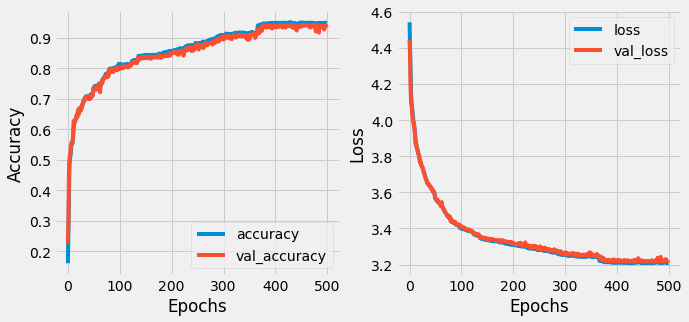

In [0]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right', fontsize=14)
plt.subplot(2,2,2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right', fontsize=14)
plt.show()

# Model Evaluation

In [0]:
model.evaluate(test_aug)[1]

20/20 [==============================] - 4s 181ms/step - loss: 3.2212 - accuracy: 0.9373


0.9373015761375427

In [0]:
model.evaluate(X_test,y_test)[1]

79/79 [==============================] - 4s 57ms/step - loss: 3.2212 - accuracy: 0.9373


0.9373015761375427

In [0]:
y_test = np.argmax(y_test,axis=1)
y_pred = model.predict(X_test, batch_size=128)
y_pred = np.argmax(y_pred,axis=1)

In [0]:
from sklearn.metrics import classification_report
import pandas as pd
report = classification_report(y_test, y_pred,output_dict=True)
df = pd.DataFrame(report).transpose()

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Visualiztion of Accuracy on each image class

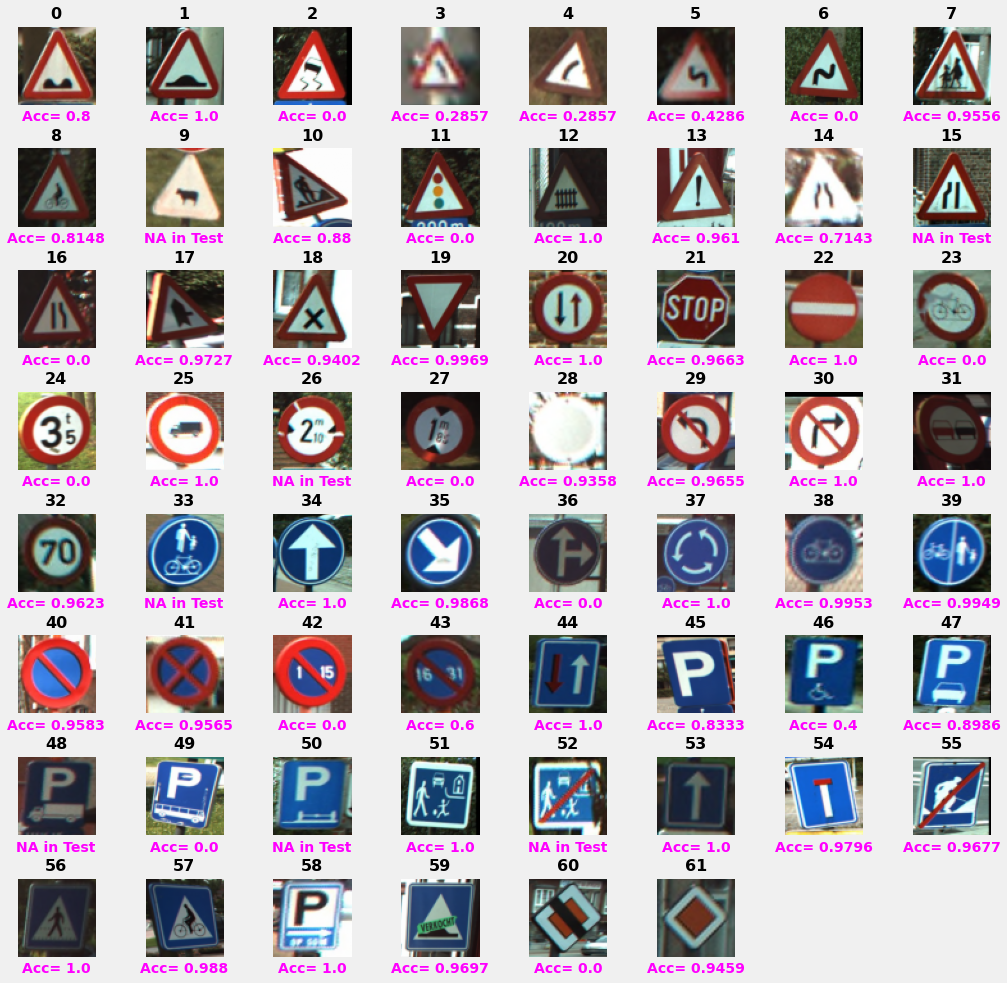

In [0]:
plt.figure(figsize=(16,16))
plt.subplots_adjust(hspace=0.5)
for j, label in enumerate(np.unique(np.argmax(y_train, axis=1))):
    for i,img in enumerate(X_train):
        if label == np.argmax(y_train, axis=1)[i]:
            plt.subplot(8,8,j+1)
            plt.grid(False)
            plt.xticks([])
            plt.yticks([])
            plt.title(label, fontsize=16,fontweight='bold')
            if str(j) in list(df.index):
                plt.xlabel('Acc= ' + str(round(df['f1-score'][str(j)],4)),color='magenta', fontsize=14,fontweight='bold')
            else:
                plt.xlabel('NA in Test', color='magenta', fontsize=14, fontweight='bold')
            plt.imshow(img)
            break